# List Runs

In [1]:
root = "../data/011221_rov_tests"
run_list = '.run_list.temp'
!ls {root} -1 | tee {run_list}

011221_rov_tests_scan_plan.ggb
011221_rov_tests_scan_plan.svg
1_static_1
1_static_2
2_sway_1
2_sway_2
2_sway_3
3_surge_1
3_surge_2
4_verticalsway_1
5_verticalsurge_1
6_horizsquare_1
7_line_1


In [2]:
runs = [a.strip() for a in open(run_list) if a != '']

In [3]:
fs = 100
dt = 1.0 / fs

# Helpers

In [4]:
import numpy as np

from scipy.signal import butter, lfilter, filtfilt, hilbert
class BP:
    def __init__(self, fs=fs, low=30e3, high=50e3, order=5, preserve_phase=False):
        nyq = 0.5 * fs
        self.coeffs = butter(order, [low / nyq, high / nyq], btype='band')
        self.apply = filtfilt if preserve_phase else lfilter

    def __call__(self, data):
        return self.apply(*self.coeffs, data, axis=0)
    
class LP:
    def __init__(self, fs=fs, low=30, order=5, preserve_phase=False):
        nyq = 0.5 * fs
        self.coeffs = butter(order, low / nyq, btype='lowpass')
        self.apply = filtfilt if preserve_phase else lfilter

    def __call__(self, data):
        return self.apply(*self.coeffs, data, axis=0)


In [5]:
import numpy as np

def rolling_window(a, window):
    pad = np.ones(len(a.shape), dtype=np.int32)
    pad[-1] = window-1
    pad = list(zip(pad, np.zeros(len(a.shape), dtype=np.int32)))
    a = np.pad(a, pad,mode='reflect')
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

# Load Run

In [6]:
import numpy as np

In [7]:
run = runs[runs.index('2_sway_3')]  #runs[8]
run

'2_sway_3'

In [8]:
imu_file = f"{root}/{run}/imu.csv"
times_file = f"{root}/{run}/times.log"
!du -h {imu_file}
!cat {times_file}

768K	../data/011221_rov_tests/2_sway_3/imu.csv
1638364620.017882 
1638364629.994484 
1638364637.5251446 
1638364646.7648823 
1638364654.2210188 
1638364660.5617583 


In [9]:
imu_orig = np.loadtxt(imu_file, delimiter=',', skiprows=1)

In [10]:
t = imu_orig[:, 0] - imu_orig[0,0]
imu = imu_orig[:, 1:].copy()
imu[:, 3:6] -= imu[:int(fs * 5), 3:6].mean(axis=0)
imu[:, 6:9] -= imu[:int(fs * 5), 6:9].mean(axis=0)
imu_labels = open(imu_file).readline().strip().split(', ')[1:]
print(open(imu_file).readline().strip().split(', '))

['time', 'yaw', 'pitch', 'roll', 'a_n', 'a_e', 'a_d', 'w_y', 'w_p', 'w_r']


In [11]:
imu[:, 3:6] = LP(fs=fs, low=30)(imu_orig[:, 4:7])

In [12]:
times = {}
for l in open(times_file, 'r'):
    vals = l[:-1].split(' ')[0:2]
    times[float(vals[0]) - imu_orig[0,0]] = vals[1]

# times

# Simple Viz

In [13]:
import matplotlib.pyplot as plt

In [14]:
imu[:, 3:6] = LP(fs=fs, low=5)(imu_orig[:, 4:7])

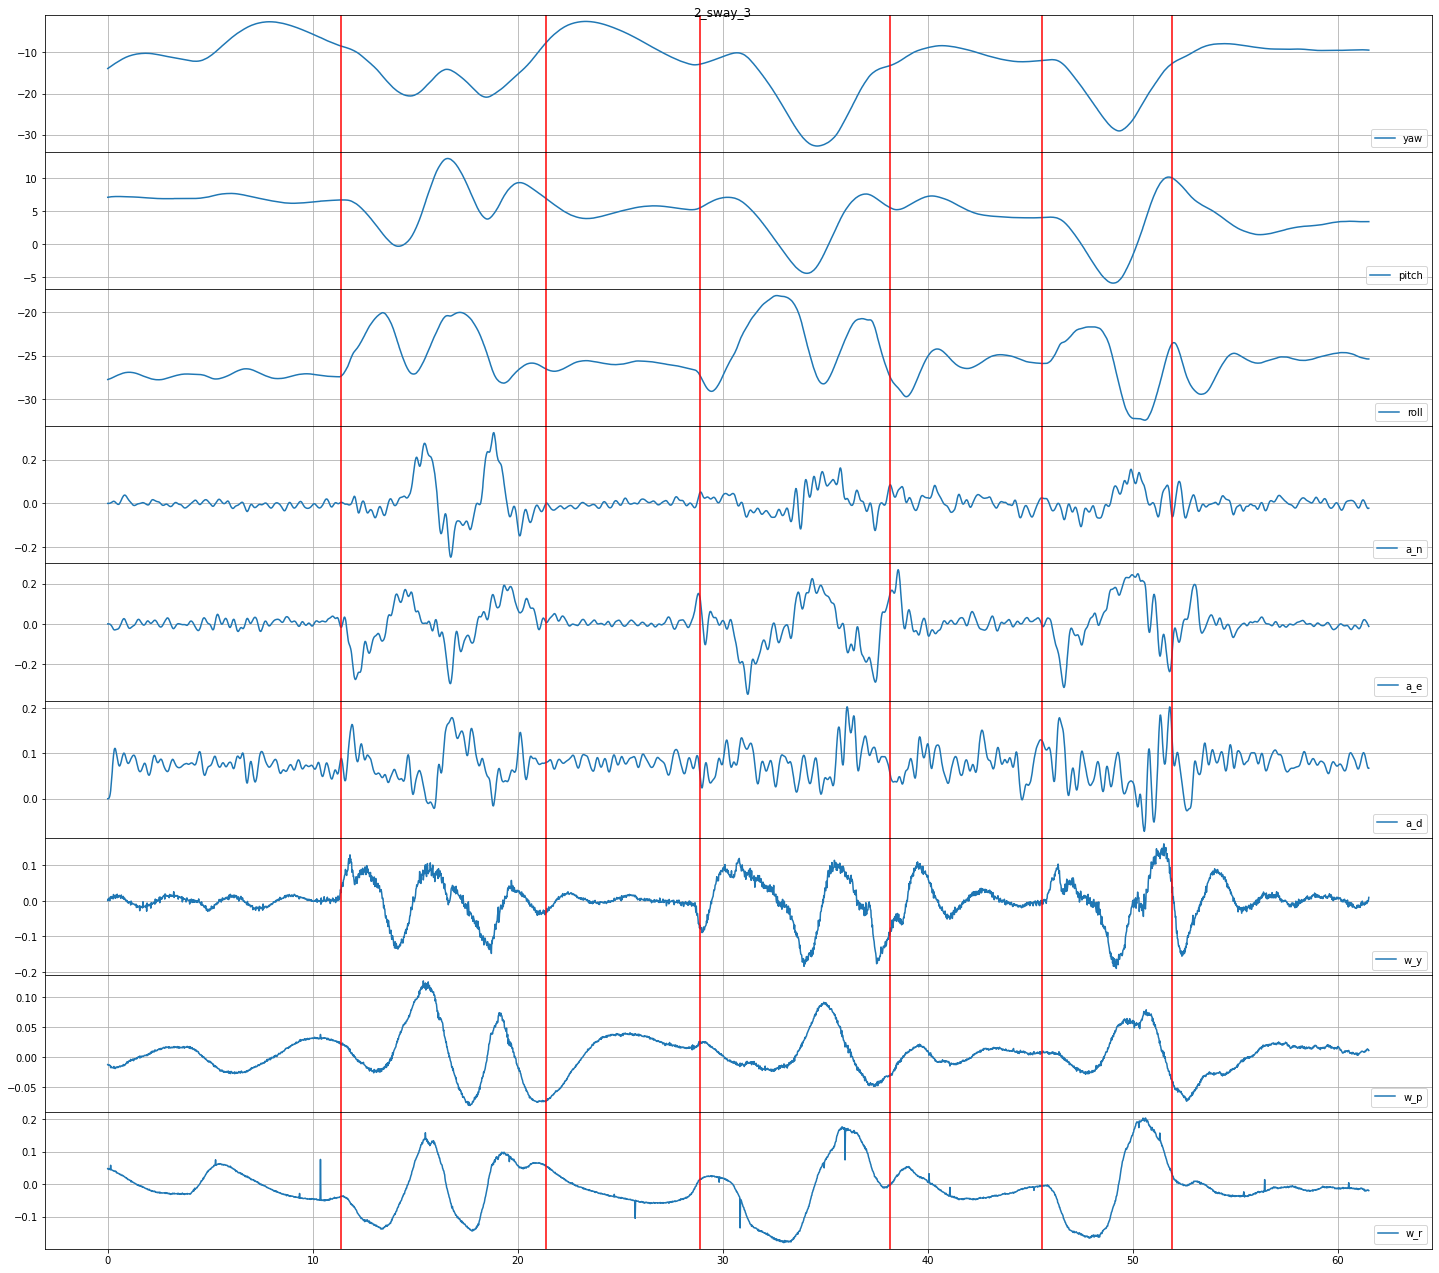

In [15]:
f, ax = plt.subplots(imu.shape[1], 1, figsize=(20, 2 * imu.shape[1]), sharex=True)

for i in range(imu.shape[1]):
    ax[i].plot(t, imu[:, i], label=imu_labels[i])
    for tt in times.keys():
        ax[i].axvline(tt, color='red')
    ax[i].grid()
    ax[i].legend(loc='lower right')
f.suptitle(run)
f.tight_layout()
f.subplots_adjust(wspace=0, hspace=0)
plt.show()

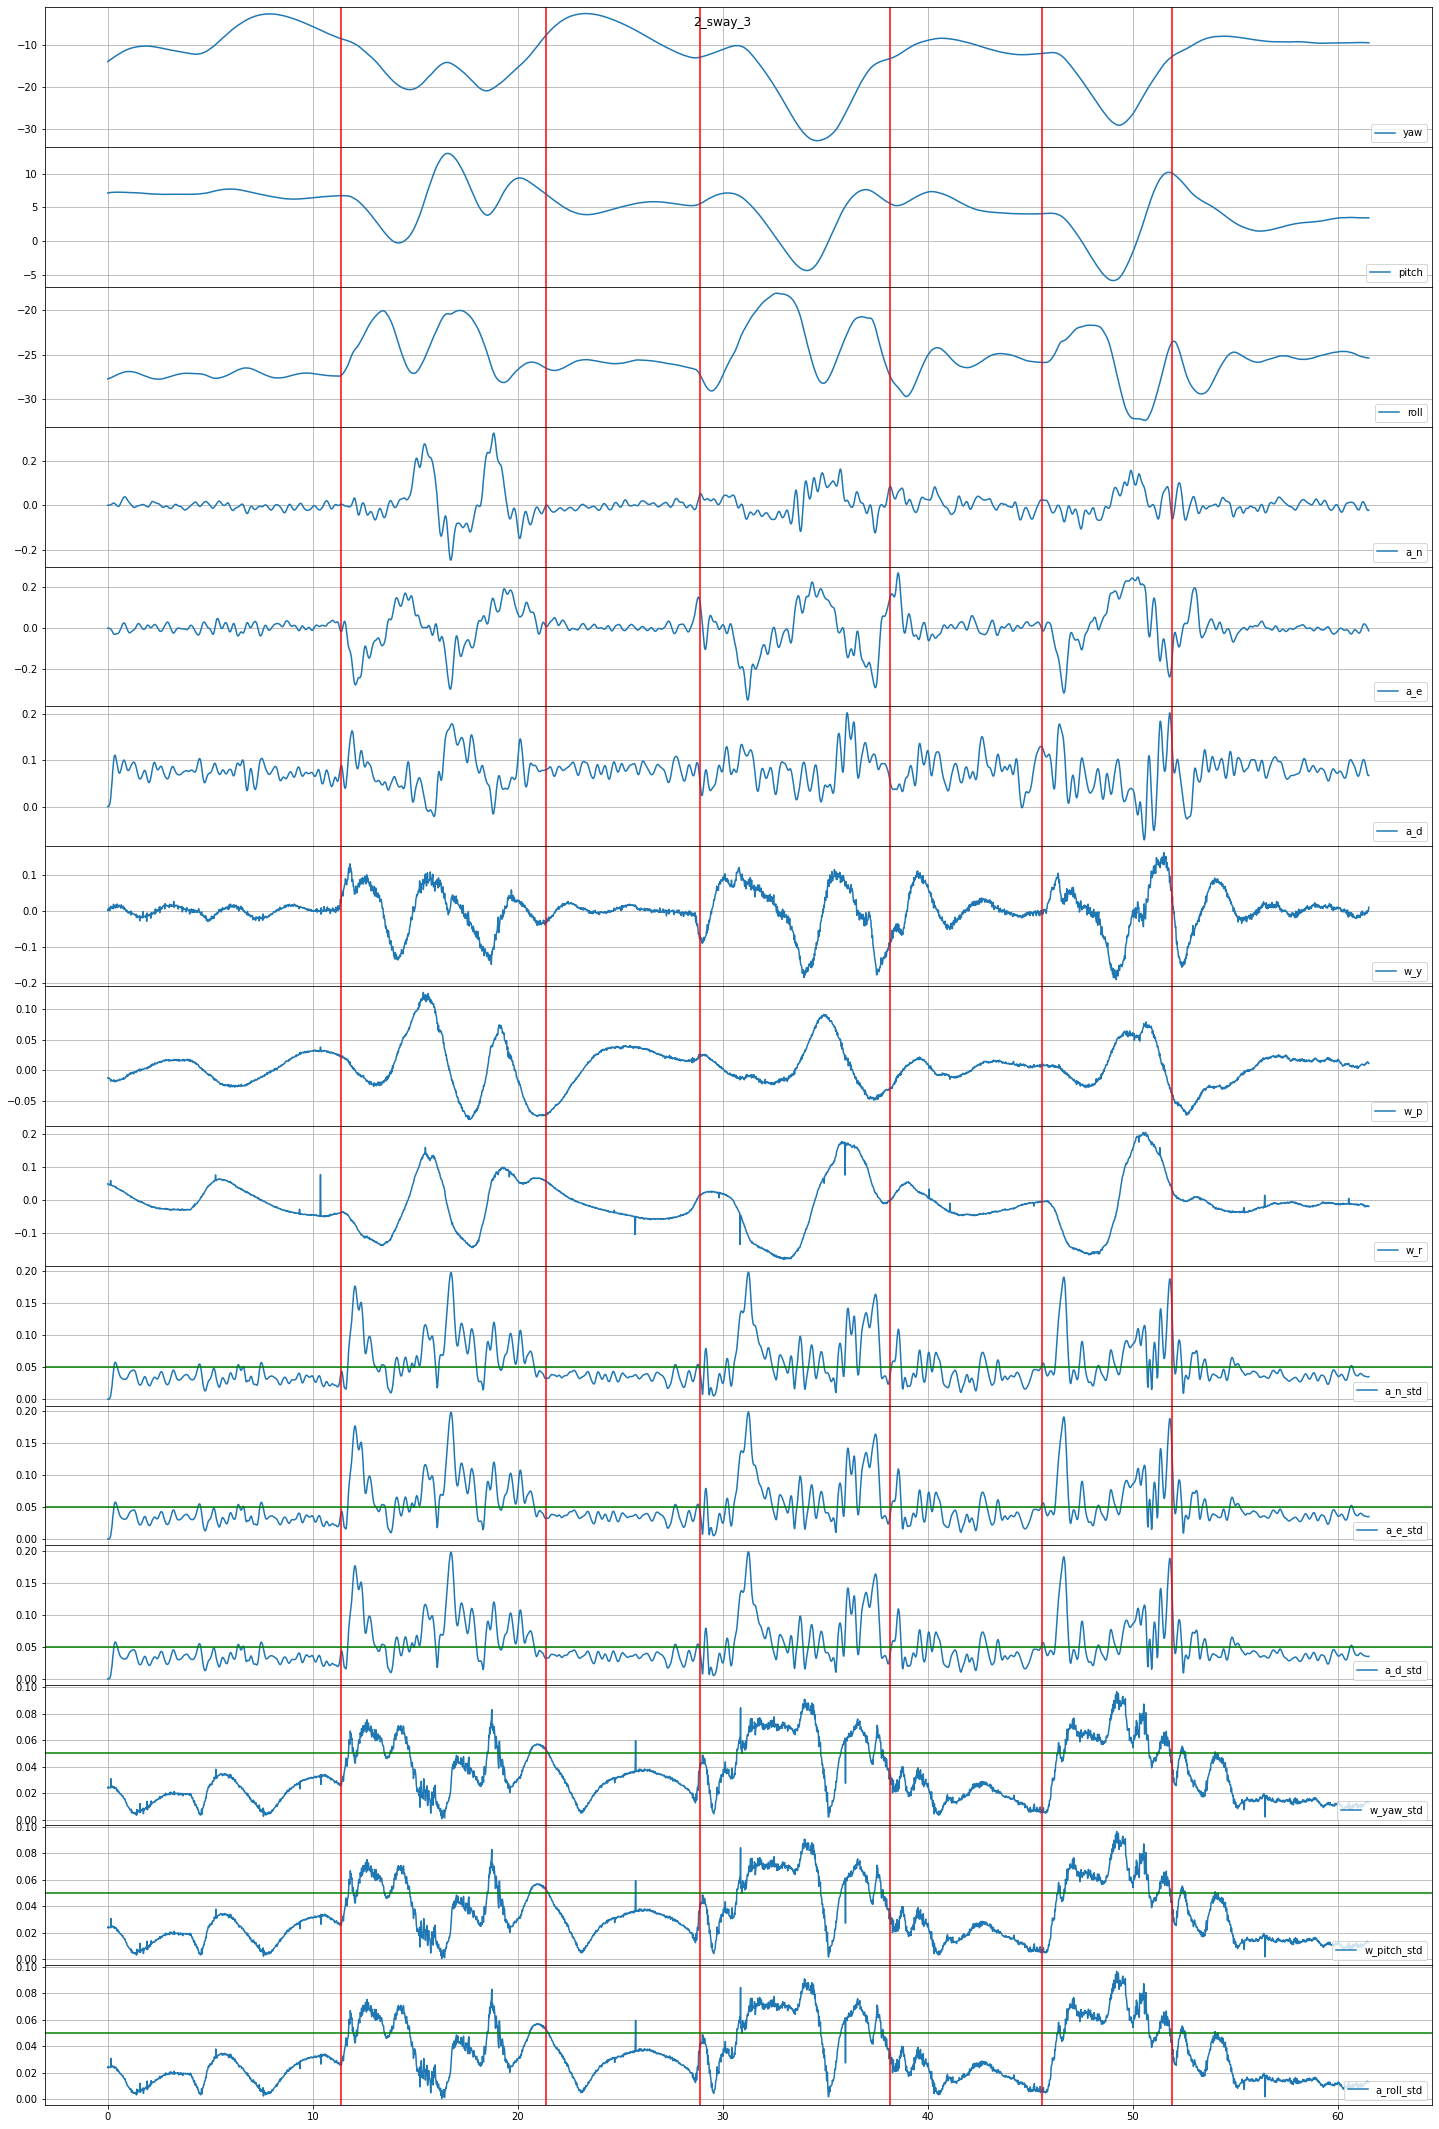

In [16]:
f, ax = plt.subplots(imu.shape[1] + 6, 1, figsize=(20, 2 * (imu.shape[1] + 6)), sharex=True)

for i in range(imu.shape[1]):
    ax[i].plot(t, imu[:, i], label=imu_labels[i])
    for tt in times.keys():
        ax[i].axvline(tt, color='red')
    ax[i].grid()
    ax[i].legend(loc='lower right')
    
acc_std = rolling_window(imu[:, 3:6], int(fs * 0.4)).std(axis=-1)

for a, std, name in zip(ax[imu.shape[1]:(imu.shape[1] + 3)], acc_std.T, ('a_n_std', 'a_e_std', 'a_d_std',)):
    a.plot(t, std[:-1], label=name)
    for tt in times.keys():
        a.axvline(tt, color='red')
    a.axhline(0.05, color='green')
    a.grid()
    a.legend(loc='lower right')
    

w_std = rolling_window(imu[:, 6:9], int(fs * 0.4)).std(axis=-1)

for a, std, name in zip(ax[imu.shape[1] + 3:(imu.shape[1] + 6)], w_std.T, ('w_yaw_std', 'w_pitch_std', 'a_roll_std',)):
    a.plot(t, std[:-1], label=name)
    for tt in times.keys():
        a.axvline(tt, color='red')
    a.axhline(0.05, color='green')
    a.grid()
    a.legend(loc='lower right')
    
    
f.suptitle(run)
f.tight_layout()
f.subplots_adjust(wspace=0, hspace=0)
plt.show()

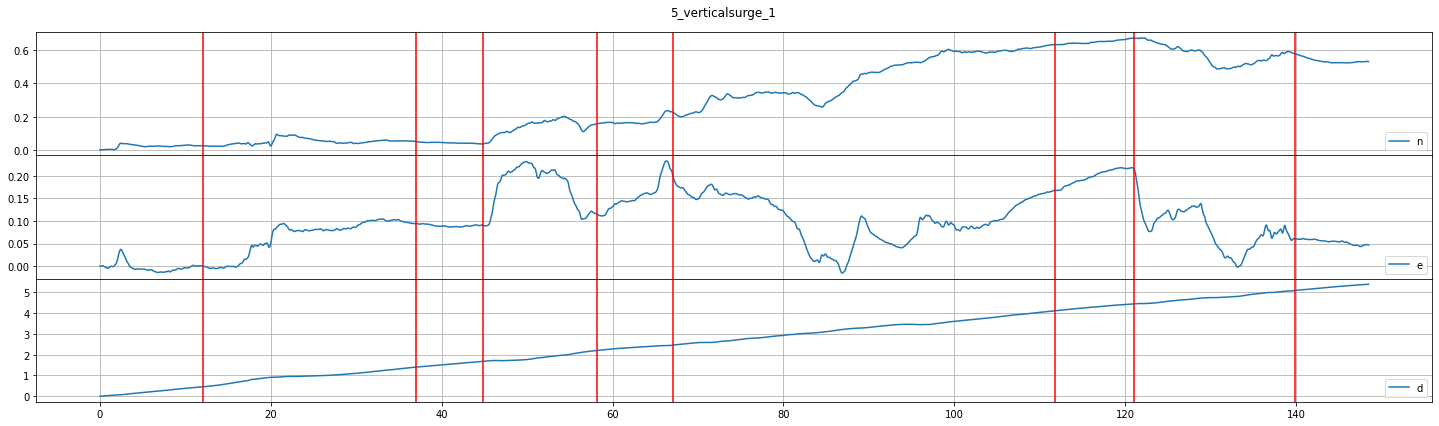

In [97]:
v = dt * np.cumsum(imu[:, 3:6], axis=0)

f, ax = plt.subplots(v.shape[1], 1, figsize=(20, 2 * v.shape[1]), sharex=True)

for i in range(v.shape[1]):
    ax[i].plot(t, v[:, i], label=('n e d'.split(' '))[i])
    for tt in times.keys():
        ax[i].axvline(tt, color='red')
    ax[i].grid()
    ax[i].legend(loc='lower right')
f.suptitle(run)
f.tight_layout()
f.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Basic Plot List

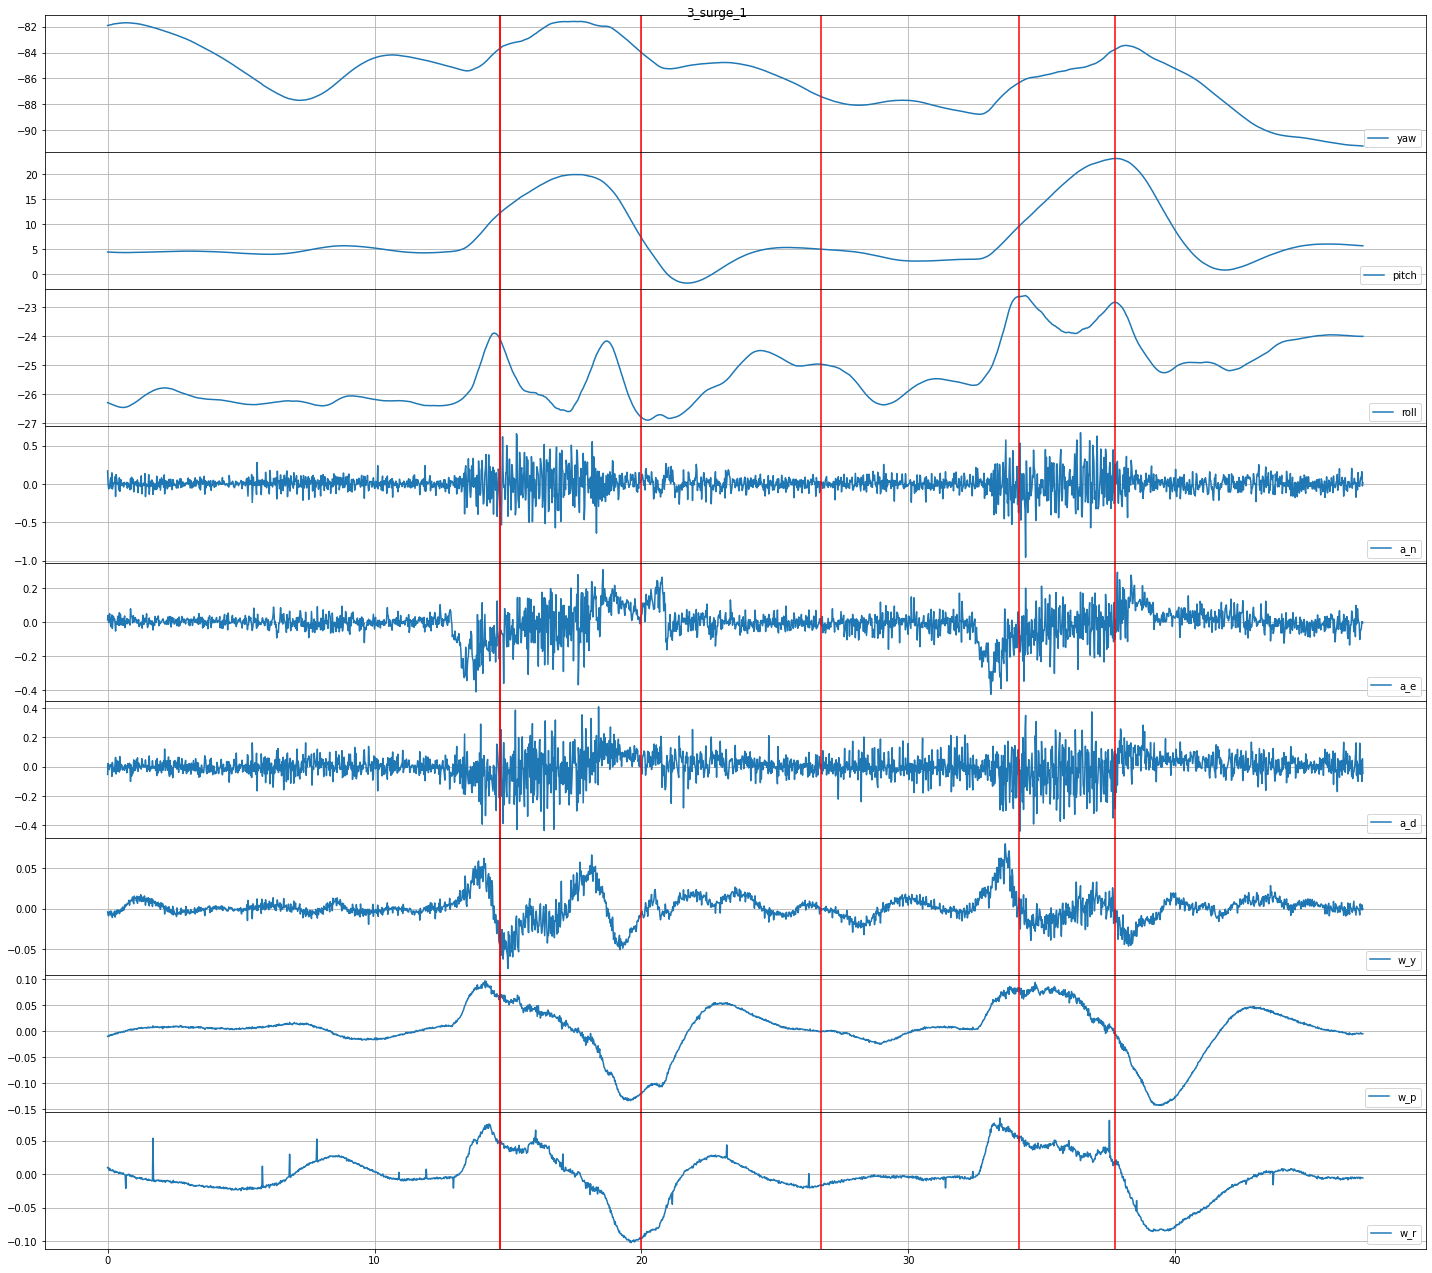

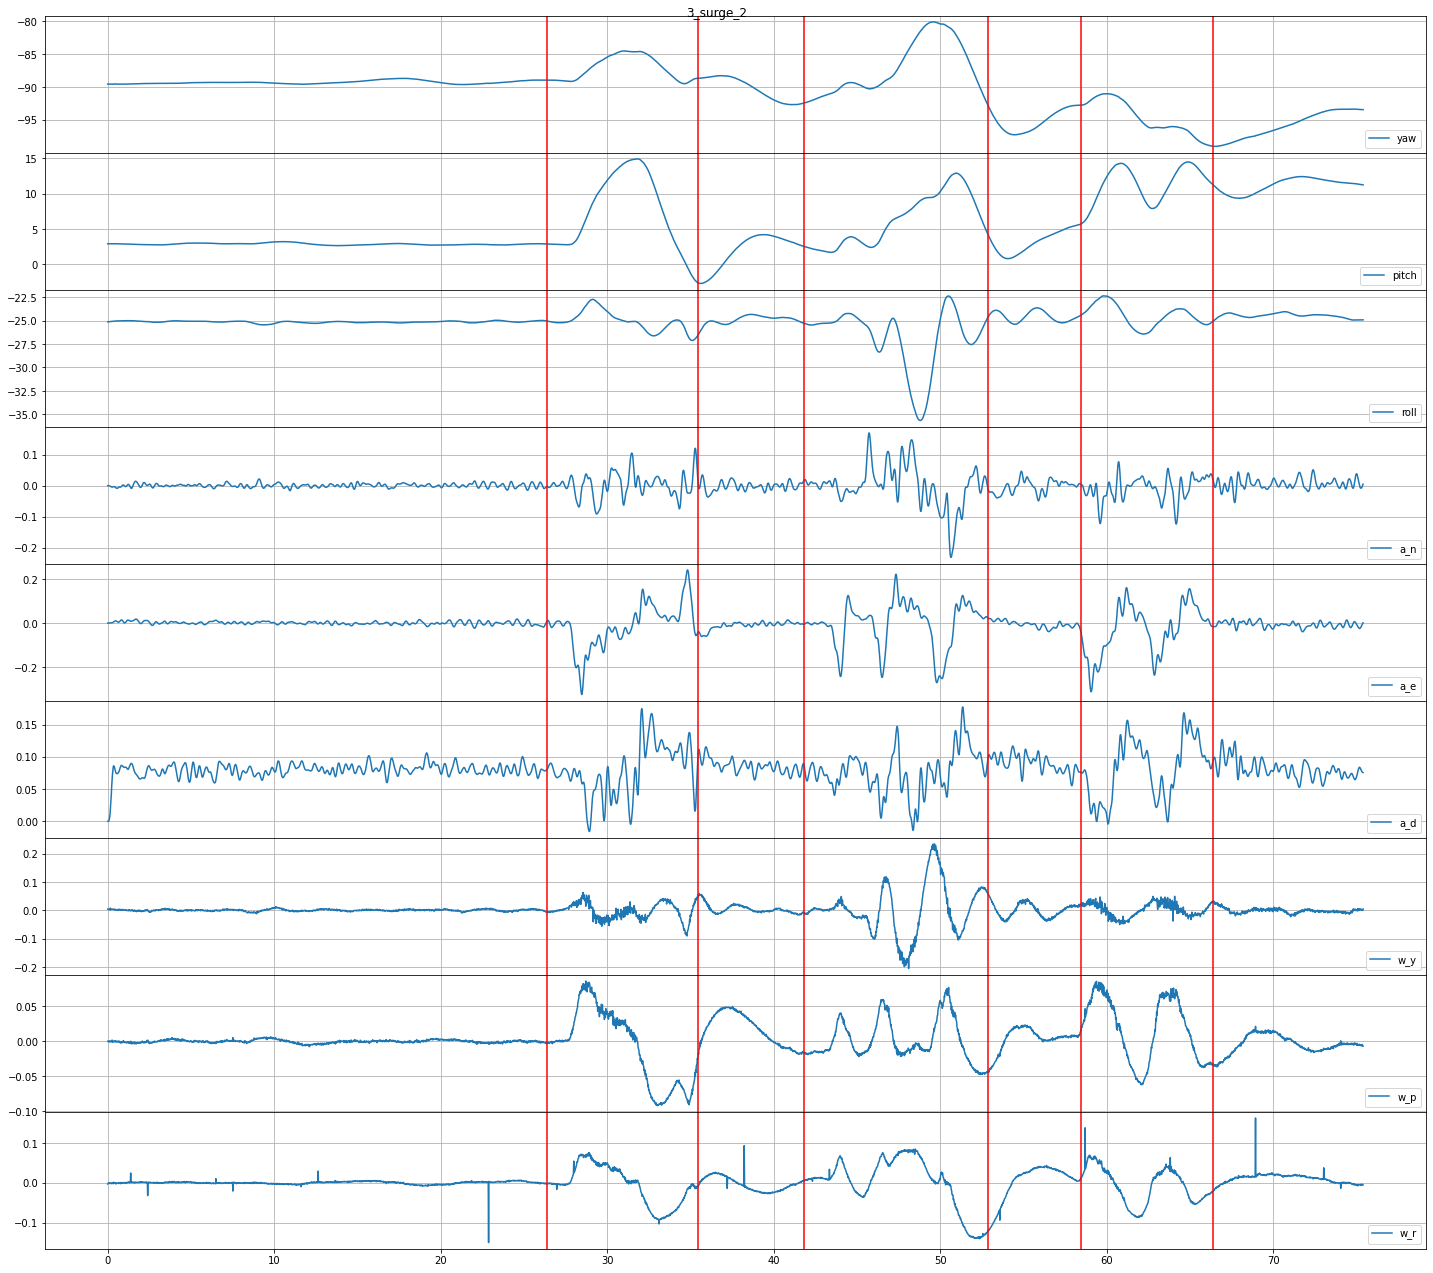